# 1. DataFrame details

### The benefits for using Spark for data cleaning.
* Spark is able to process that millions or even billions of pieces of data. 
* Scale the data processing capacity as the requirements evolve. 
* Beyond the performance issues, dealing with large quantities of data requires a process, or pipeline of steps. Spark allows management of many complex tasks within a single framework.
* Spark offers high performance.
* Spark allows orderly data flows.
* Spark can use strictly defined schemas while ingesting data.

## Defining a schema
Creating a defined schema helps with data quality and import performance. 

In [2]:
# Import the pyspark.sql.types library
from pyspark.sql.types import *

# Define a new schema using the StructType method
people_schema = StructType([
  # Define a StructField for each field
  StructField('name', StringType(), False),
  StructField('age', IntegerType(), True),
  StructField('city', StringType(), True)
])

### Immutability and lazy processing
* Spark is designed to use immutable objects. Practically, this means Spark Data Frames are defined once and are not modifiable after initialization. If the variable name is reused, the original data is removed (assuming it's not in use elsewhere) and the variable name is reassigned to the new data. While this seems inefficient, it actually allows Spark to share data between all cluster components. It can do so without worry about concurrent data objects.<br>
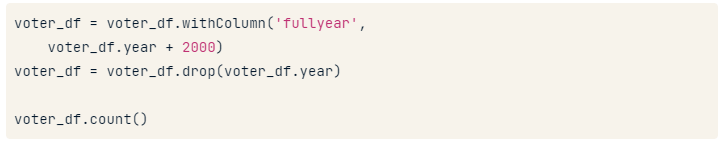<br>
Please note that the original year column is now permanently gone from this instance, though not from the underlying data.<br><br>
* Lazy processing in Spark is the idea that very little actually happens until an action is performed. In our previous example, we read a CSV file, added a new column, and deleted another. The trick is that no data was actually read / added / modified, we only updated the instructions (aka, Transformations) for what we wanted Spark to do. This functionality allows Spark to perform the most efficient set of operations to get the desired result. 

The code example is the same as the previous slide, but with the added count() method call. This classifies as an action in Spark and will process all the transformation operations.

## Using lazy processing


In [1]:
# Import pyspark.sql.functions as F
import pyspark.sql.functions as F

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession 

# Create my_spark
spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(spark)

In [6]:
# Load the CSV file
aa_dfw_df = spark.read.format('csv').options(Header=True).load('AA_DFW_2017_Departures_Short.csv.gz')

# Add the airport column using the F.lower() method
aa_dfw_df = aa_dfw_df.withColumn('airport', F.lower(aa_dfw_df['Destination Airport']))

# Drop the Destination Airport column
aa_dfw_df = aa_dfw_df.drop(aa_dfw_df['Destination Airport'])

# Show the DataFrame
aa_dfw_df.show()

+-----------------+-------------+-----------------------------+-------+
|Date (MM/DD/YYYY)|Flight Number|Actual elapsed time (Minutes)|airport|
+-----------------+-------------+-----------------------------+-------+
|       01/01/2017|         0005|                          537|    hnl|
|       01/01/2017|         0007|                          498|    ogg|
|       01/01/2017|         0037|                          241|    sfo|
|       01/01/2017|         0043|                          134|    dtw|
|       01/01/2017|         0051|                           88|    stl|
|       01/01/2017|         0060|                          149|    mia|
|       01/01/2017|         0071|                          203|    lax|
|       01/01/2017|         0074|                           76|    mem|
|       01/01/2017|         0081|                          123|    den|
|       01/01/2017|         0089|                          161|    slc|
|       01/01/2017|         0096|                           84| 

## Understanding Parquet
### The Parquet Format
* columnar data format 
* supported in spark and other data processing frameworks
* supports predicate pushdown
* automatically stores schema information 
* binary file format <br>
`predicate pushdown` This means Spark will only process the data necessary to complete the operations you define versus reading the entire dataset.<br>
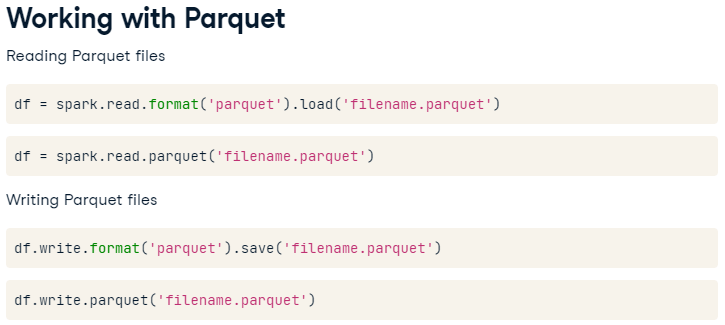

In [38]:
# Load the CSV file
df1 = spark.read.format('csv').options(Header=True).load('AA_DFW_2014_Departures_Short.csv.gz')
# Rename the column
df1 = df1.withColumnRenamed("Date (MM/DD/YYYY)", "Date")
df1 = df1.withColumnRenamed("Flight Number", "Flight_Number")
df1 = df1.withColumnRenamed("Destination Airport", "Destination_Airport")
df1 = df1.withColumnRenamed("Actual elapsed time (Minutes)", "flight_duration")

# Load the CSV file
df2 = spark.read.format('csv').options(Header=True).load('AA_DFW_2015_Departures_Short.csv.gz')
# Rename the Date (MM/DD/YYYY) column
df2 = df2.toDF("Date","Flight_Number","Destination_Airport","flight_duration")

#### 2 way to rename the multiple columns ^^^

## Saving a DataFrame in Parquet format

In [39]:
# View the row count of df1 and df2
print("df1 Count: %d" % df1.count())
print("df2 Count: %d" % df2.count())

# Combine the DataFrames into one
df3 = df1.union(df2)

# Save the df3 DataFrame in Parquet format
df3.write.parquet('AA_DFW_ALL.parquet', mode='overwrite')

# Read the Parquet file into a new DataFrame and run a count
print(spark.read.parquet('AA_DFW_ALL.parquet').count())

df1 Count: 157198
df2 Count: 146558
303756


## SQL and Parquet
Parquet files are perfect as a backing data store for SQL queries in Spark. While it is possible to run the same queries directly via Spark's Python functions, sometimes it's easier to run SQL queries alongside the Python options.!<br>
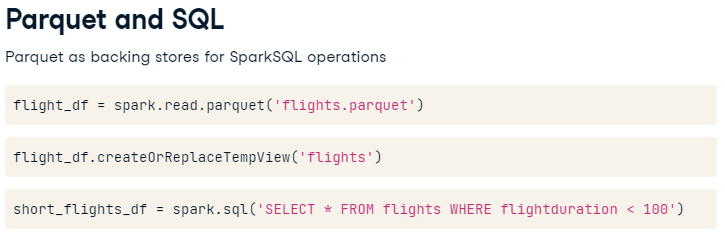

In [40]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession 

In [42]:
# Read the Parquet file into flights_df
flights_df = spark.read.parquet('AA_DFW_ALL.parquet')

# Register the temp table
flights_df.createOrReplaceTempView('flights')

# Run a SQL query of the average flight duration
avg_duration = spark.sql('SELECT avg(flight_duration) from flights').collect()[0]
print('The average flight time is: %d' % avg_duration)

The average flight time is: 143


# 2. Manipulating DataFrames in the real world

## DataFrame column operations
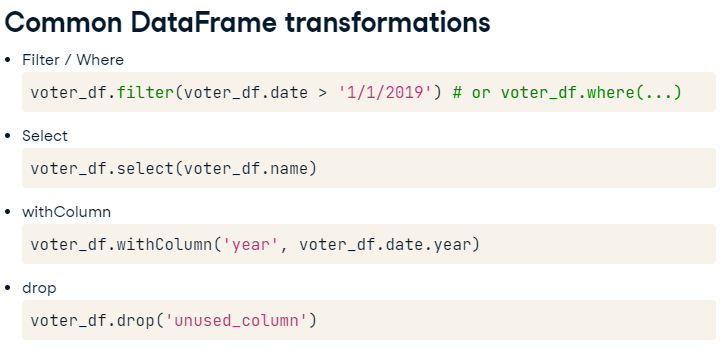

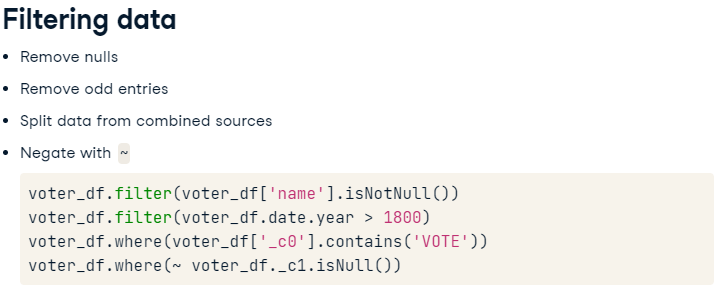

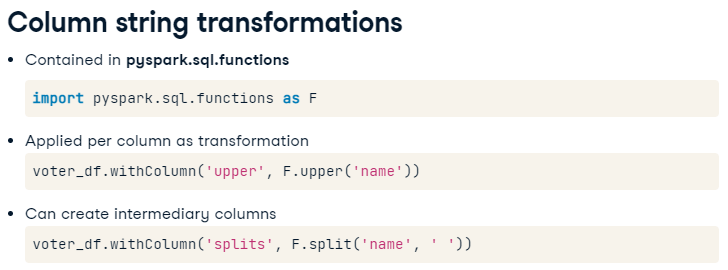

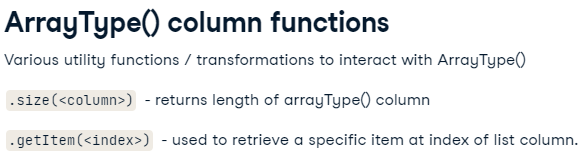